# general imports

In [1]:
from __future__ import division, print_function

import numpy as np

from scipy.constants import m_p, c, e

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# works only if PyCUDA is available for GPU usage
try:
    import pycuda.autoinit
    has_pycuda = True
except ImportError:
    has_pycuda = False

In [3]:
# sets the PyHEADTAIL directory etc.
from settings import *

# PyHEADTAIL imports

In [4]:
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems
import PyHEADTAIL.aperture.aperture as aperture

PyHEADTAIL v1.10.5.268




# Setting up the machine and functions

In [5]:
# machine parameters
circumference = 157.
inj_alpha_x = 0
inj_alpha_y = 0
inj_beta_x = 5.9 # in [m]
inj_beta_y = 5.7 # in [m]
Qx = 5.1
Qy = 6.1
gamma_tr = 4.05
alpha_c_array = [gamma_tr**-2]
V_rf = 8e3 # in [V]
harmonic = 1
phi_offset = 0 # measured from aligned focusing phase (0 or pi)
pipe_radius = 5e-2

# beam parameters
Ekin = 1.4e9 # in [eV]
intensity = 1.684e12
epsn_x = 2.5e-6 # in [m*rad]
epsn_y = 2.5e-6 # in [m*rad]
epsn_z = 1.2 # 4pi*sig_z*sig_dp (*p0/e) in [eVs]

# calculations
gamma = 1 + e * Ekin / (m_p * c**2)
beta = np.sqrt(1 - gamma**-2)
eta = alpha_c_array[0] - gamma**-2
if eta < 0:
    phi_offset = np.pi - phi_offset
Etot = gamma * m_p * c**2 / e
p0 = np.sqrt(gamma**2 - 1) * m_p * c
Qs = np.sqrt(np.abs(eta) * V_rf / (2 * np.pi * beta**2 * Etot))
beta_z = np.abs(eta) * circumference / (2 * np.pi * Qs)

In [6]:
def plot_phase_space(bunch, ax0, ax1, ax2, col):
    # phase spaces
    ax0.scatter(bunch.x, bunch.xp, color=col)
    ax1.scatter(bunch.y, bunch.yp, color=col)
    ax2.scatter(bunch.z, bunch.dp, color=col)
    ax0.set_xlabel('$x$')
    ax0.set_ylabel('$x\'$')
    ax1.set_xlabel('$y$')
    ax1.set_ylabel('$y\'$')
    ax2.set_xlabel('$z$')
    ax2.set_ylabel('$z\'$')
    # statistical quantities
    ax0.scatter(bunch.mean_x(), bunch.mean_xp(), color='red')
    ax1.scatter(bunch.mean_y(), bunch.mean_yp(), color='red')
    ax2.scatter(bunch.mean_z(), bunch.mean_dp(), color='red')

def generate_bunch(n_particles):
    np.random.seed(0)
    bunch = generate_Gaussian6DTwiss(
        n_particles, intensity, e, m_p, circumference, gamma=gamma,
        alpha_x=inj_alpha_x, beta_x=inj_beta_x, epsn_x=epsn_x,
        alpha_y=inj_alpha_y, beta_y=inj_beta_y, epsn_y=epsn_y,
        beta_z=beta_z, epsn_z=epsn_z
        )
    return bunch

# Let's go

The `RectangularAperture<X,Y,Z>` classes provide an aperture as an interval in the horizontal, vertical or longitudinal direction, respectively.

The blue particles will get lost while the green ones are within the aperture boundaries:

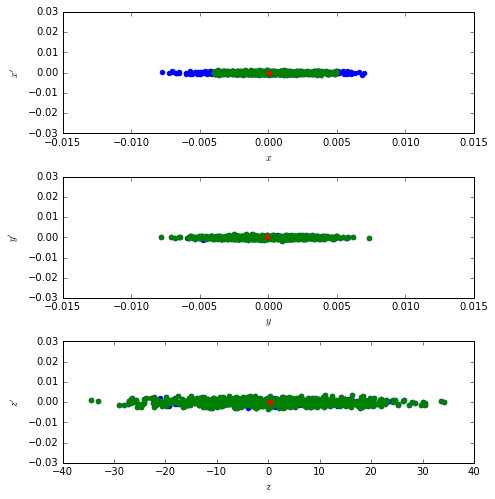

In [7]:
# (I) RectangularApertureX
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(7, 7))

bunch = generate_bunch(1000)
plot_phase_space(bunch, ax0, ax1, ax2, col='b')

apt_x = aperture.RectangularApertureX(x_low=-0.004, x_high=0.005)
apt_x.track(bunch)

plot_phase_space(bunch, ax0, ax1, ax2, col='g')
plt.tight_layout()

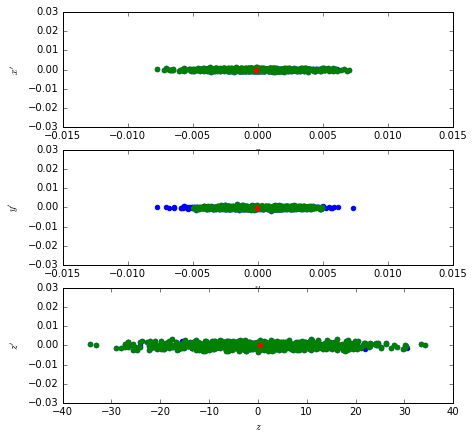

In [8]:
# (II) RectangularApertureY
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(7, 7))

bunch = generate_bunch(1000)
plot_phase_space(bunch, ax0, ax1, ax2, col='b')

apt_y = aperture.RectangularApertureY(y_low=-0.005, y_high=0.005)
apt_y.track(bunch)

plot_phase_space(bunch, ax0, ax1, ax2, col='g')
plt.show()

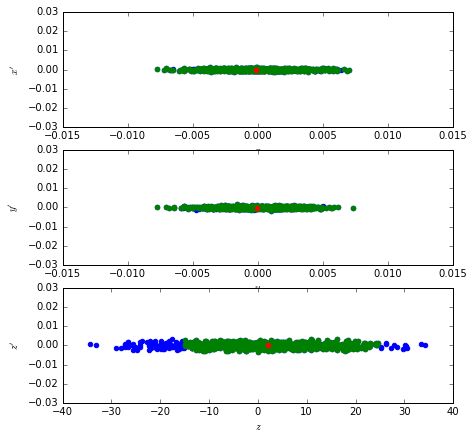

In [9]:
# (III) RectangularApertureZ
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(7, 7))

bunch = generate_bunch(1000)
plot_phase_space(bunch, ax0, ax1, ax2, col='b')

apt_z = aperture.RectangularApertureZ(z_low=-15, z_high=25)
apt_z.track(bunch)

plot_phase_space(bunch, ax0, ax1, ax2, col='g')
plt.show()

The `CircularApertureXY` keeps particles within a transverse circle of a given radius while the outer ones are lost:

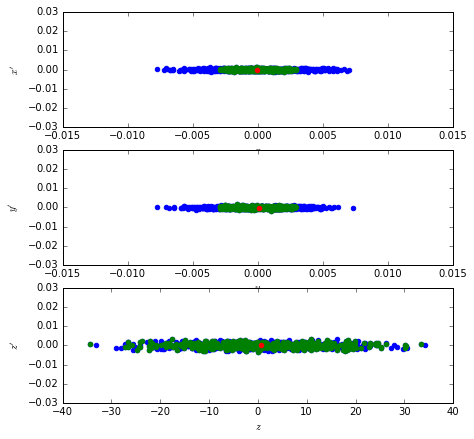

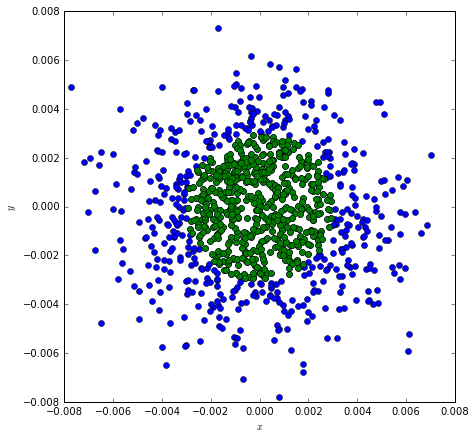

In [10]:
# (IV) CircularApertureXY
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(7, 7))

bunch = generate_bunch(1000)
plot_phase_space(bunch, ax0, ax1, ax2, col='b')
fig2, axy = plt.subplots(1, 1, figsize=(7, 7))
axy.plot(bunch.x, bunch.y, 'ob')

apt_xy = aperture.CircularApertureXY(radius=0.003)
apt_xy.track(bunch)

plot_phase_space(bunch, ax0, ax1, ax2, col='g')

axy.plot(bunch.x, bunch.y, 'og')
axy.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$');

The `EllipticalApertureXY` class allows to define an elliptical vacuum chamber boundary:

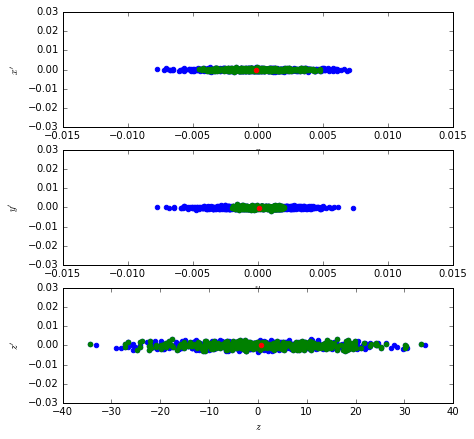

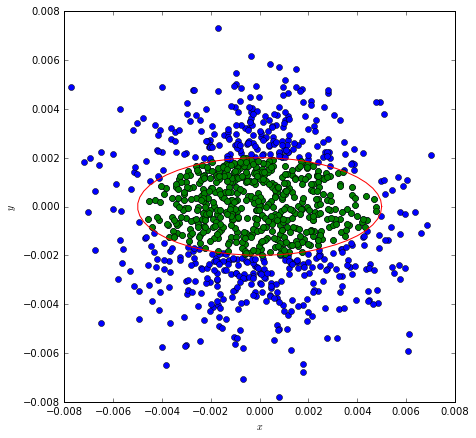

In [11]:
# (V) EllipticalApertureXY

fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(7, 7))

bunch = generate_bunch(1000)
plot_phase_space(bunch, ax0, ax1, ax2, col='b')
fig2, axy = plt.subplots(1, 1, figsize=(7, 7))
axy.plot(bunch.x, bunch.y, 'ob')

x_aper = 5e-3
y_aper = 2e-3

apt_xy = aperture.EllipticalApertureXY(x_aper=x_aper, y_aper=y_aper)
apt_xy.track(bunch)

plot_phase_space(bunch, ax0, ax1, ax2, col='g')

axy.plot(bunch.x, bunch.y, 'og')
ttt = np.linspace(0,2*np.pi)
axy.plot(x_aper*np.cos(ttt), y_aper*np.sin(ttt), 'r')

axy.axis('equal')
plt.xlabel('$x$')
plt.ylabel('$y$');

# Performance

The performance can be significantly increased if the cython module is used for the CPU version.

If a GPU is available via PyCUDA then we can achieve even further speed up:

In [12]:
from PyHEADTAIL.aperture import aperture_cython
from PyHEADTAIL.general.contextmanager import GPU

### (I) RectangularApertureX (same as Y, and Z)

In [13]:
# a. python version
bunch = generate_bunch(int(1e6))
apt_x = aperture.RectangularApertureX(x_low=-0.006, x_high=0.008)
res = %timeit -q -o apt_x.track(bunch)
res

<TimeitResult : 100 loops, best of 3: 4.62 ms per loop>

In [14]:
# b. cython version
bunch = generate_bunch(int(1e6))
apt_x = aperture_cython.RectangularApertureX(x_low=-0.006, x_high=0.008)
res = %timeit -q -o apt_x.track(bunch)
res

<TimeitResult : 100 loops, best of 3: 2.22 ms per loop>

In [15]:
# c. PyCUDA (GPU) version
bunch = generate_bunch(int(1e6))
apt_x = aperture.RectangularApertureX(x_low=-0.006, x_high=0.008)
with GPU(bunch) as contextmanager:
    res = %timeit -q -o -n 100 apt_x.track(bunch)
res

<TimeitResult : 100 loops, best of 3: 1.14 ms per loop>

### (II) CircularApertureXY

In [16]:
# a. python version
bunch = generate_bunch(int(1e6))
apt_xy = aperture.CircularApertureXY(radius=0.0076)
res = %timeit -q -o apt_xy.track(bunch)
res

<TimeitResult : 100 loops, best of 3: 7.18 ms per loop>

In [17]:
# b. cython version
bunch = generate_bunch(int(1e6))
apt_xy = aperture_cython.CircularApertureXY(radius=0.0076)
res = %timeit -q -o apt_xy.track(bunch)
res

<TimeitResult : 100 loops, best of 3: 2.79 ms per loop>

In [18]:
# c. PyCUDA (GPU) version
bunch = generate_bunch(int(1e6))
apt_xy = aperture.CircularApertureXY(radius=0.0076)
with GPU(bunch) as contextmanager:
    res = %timeit -q -o -n 100 apt_xy.track(bunch)
res

<TimeitResult : 100 loops, best of 3: 1.16 ms per loop>